In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from math import *
from copy import *
import copy
import pickle
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2019)
from langdetect import detect
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from pprint import pprint

[nltk_data] Downloading package wordnet to /Users/bennett/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

def flatten_df(input_df, flatten_col):
    cols = list(input_df.columns)
    other_cols = [c for c in cols if not c == flatten_col]
    fc_flat = pd.DataFrame([[i,x] for i,y in input_df[flatten_col].apply(list).iteritems()
                            for x in y], columns=['I', flatten_col])
    fc_flat = fc_flat.set_index('I')
    output_df = input_df[other_cols].merge(fc_flat, left_index=True, right_index=True)
    return output_df

In [64]:
ab = flatten_df(input_df[['A', 'B']], 'B')
ac = flatten_df(input_df[['A', 'C']], 'C')
print(ab)
print(ac)

   A  B
0  1  a
0  1  b
1  2  c
   A  C
0  1  a
0  1  b
1  2  c


In [86]:
output_df = ab
output_df['C'] = flatten(input_df['C'])
print(output_df)

   A  B  C
0  1  a  a
0  1  b  b
1  2  c  c


In [342]:
def extract_topic_vectors(flat_pickle_name, 
                          tf_idf = True, n_topics = 20, npasses=5, **kwargs):
    
    """
    input: directory to a pickle, tf_idf bool, number of topics
    important kwargs: no_below (a number), no_above (between 0 and 1), keep_n (a number of words in the dictionary)
    output: an lda_model, topics, a corpus, a dictionary
    """
    
    file = open(flat_pickle_name, 'rb')
    preproc_df = pickle.load(file)
    file.close()
    print('Loaded File')
    
    corpus, dictionary = get_corpus(preproc_df, **kwargs)
    
    if tf_idf:
        tfidf = models.TfidfModel(corpus)
        corpus = tfidf[corpus]

    print('Made Corpus')
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=n_topics, id2word=dictionary, passes=npasses,
                                           workers=5)
    topics = lda_model.show_topics(num_topics=n_topics, num_words=10, log=False, formatted=True)

    return lda_model, topics, corpus, dictionary
    

In [306]:
flat_df_HOST_NAME.shape[0]*0.01

2659.54

In [652]:
fake_revs = ["I hated this listing. It had multiple problems. Unfortunately, I won't be returning. What a joke.",
"This appartment was in a very trendy neighborhood. I loved the nightlife.",
"The decor was so modern and chic!",
 "Janet was so warm and bubbly. It was a real treat to hang out with her and her adorable cat"]
fake_rev_df = pd.DataFrame({'comments':fake_revs})

In [653]:
fake_rev_df.comments.map(preprocess)

0    [hat, list, multipl, problem, unfortun, return...
1       [appart, trendi, neighborhood, love, nightlif]
2                                [decor, modern, chic]
3        [janet, warm, bubbl, real, treat, hang, ador]
Name: comments, dtype: object

In [27]:
def get_corpus(preproc_df, **kwargs):
    """
    input: a processed, flat df
    with a single row for every comment under column 'comments'
    outputs: corpus, a dict reporting how many words and how many times these words appear
    """

    processed_comments = preproc_df['comments'].map(preprocess)
    
    # Create a dictionary containing the number of times a word appears in the training set.
    dictionary = gensim.corpora.Dictionary(processed_comments)
    
    # Filter out tokens that appear in < than no_below documents (absolute number)
    # or > than no_above documents (fraction of total corpus size, not absolute number).
    # after the above two steps, keep only the first keep_n most frequent tokens.
    dictionary.filter_extremes(**kwargs)

    # Gensim doc2bow
    corpus = [dictionary.doc2bow(comment) for comment in processed_comments]
    return corpus, dictionary

In [21]:
# Tokenization: Split the text into sentences and the sentences into words. 
# Lowercase the words and remove punctuation.

# Words that have fewer than 3 characters are removed.

# Words are lemmatized — words in third person are changed to first person 
# and verbs in past and future tenses are changed into present.

# Words are stemmed — words are reduced to their root form.

# All stopwords are removed.


stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result



In [158]:
# data cleaning functions

def clean_detect(x):
    try:
        return detect(x)
    except:
        return 'No Language'
    
def name2HOST_NAME(x):
    if type(x['host_name']) is str:
        return x['comments'].replace(x['host_name'], 'HOST_NAME')
    else:
        return x['comments']

def preproc_df(df, pickle_name='', extract_host = False, change_name2HOST_NAME = False, 
               lang_condition = 'en', min_num_reviews = None):
    """
    input a df in the format of room_db
    with columns ['room_id', 'host_name', 'user_id', 'comments']
    with dtype int, str, list-of-int, list-of-str
    
    output flat_df with columns ['listing_id', 'host_name', 'user_id', 'comments', host_names_extracted, 'old_index']
    with dtype int, str, int, list-of-str, int
    
    if find_host, automatically find the name of the host(s) within a given listing
    fill a column with a list of these guesses.
    else, put an empty list
    
    args:
    lang_select selects the language of comments to condition on. 'en' for english. '' --> no filtering
    min_num_reviews: int. Filter out listings with less than min_num_reviews
    
    """
   
    
    lids = []
    hns = []
    uids = []
    flat_doc_comments = []
    host_names_extracted = []
    for index, row in df.head(n=df.shape[0]).iterrows():
        lid = row.room_id
        hn = row.host_name
        uid = row.user_id
        cs = row.comments
        lids.extend([lid]*len(cs))
        hns.extend([hn]*len(cs))
        uids.extend(uid)
        flat_doc_comments.extend(cs)
        if extract_host:
            host_names_extracted.extend(extract_host_names(cs))
        else:
            host_names_extracted.extend([[]*len(cs)])

    flat_df = pd.DataFrame({'listing_id':lids, 
                                'host_name': hns, 
                                'user_id':uids,
                                'comments':flat_doc_comments})
    
    flat_df.comments = flat_df.comments.fillna('')
    
    
    if change_name2HOST_NAME:
        flat_df['comments'] = flat_df.apply(lambda x: name2HOST_NAME(x), axis=1)

    # ONLY LOOKS AT REVIEWS WITH 3+ CHARACTERS
    # ONLY LOOK AT REVIEWS IN ENGLISH
    flat_df = flat_df[flat_df.comments.apply(lambda x: len(x) >= 3)]
    if lang_condition:
        flat_df = flat_df[flat_df.comments.apply(lambda x: clean_detect(x) == lang_condition)]

    # REMOVE AUTOMATED MESSAGES
    flat_df = flat_df[flat_df.comments.apply(lambda x: x[:34] != 'The host canceled this reservation')]

    if pickle_name:
        with open(pickle_name, 'wb') as pickle_file:
            pickle.dump(flat_df, pickle_file)

    return flat_df

In [918]:
# data loading functions

def load_room_db(listing_fnames, review_fnames, room_db_pickle_name='', load_from_pickle = False):
    
    listings = []
    reviews = []
    if load_from_pickle:        
        for fname in listing_fnames:
            file = open(fname, 'rb')
            object_file = pickle.load(file)
            listings.append(object_file)
            file.close()
        for fname in review_fnames:
            file = open(fname, 'rb')
            object_file = pickle.load(file)
            reviews.append(object_file)
            file.close()    
    else:
        for fname in listing_fnames:
            listings.append(pd.read_csv(fname, sep=';'))
        for fname in review_fnames:
            reviews.append(pd.read_csv(fname, sep=';'))
      
    # clean up column names
    l2d = {'id':'room_id', 
        'geolocation':'coordinates', 
        'neighbourhood_cleansed': 'neighborhood_clean',
       'price':'room_price',
       'last_review':'date_last_review'}
    for i, L in enumerate(listings):
        L = L.rename(columns={c:c.lower().replace(' ', '_') for c in L.columns})
        L = L.rename(columns=l2d)
        listings[i] = L
    for i, R in enumerate(reviews):
        R = R.rename(columns={c:c.lower().replace(' ', '_') for c in R.columns})
        reviews[i] = R
        
    reviews = reviews[0]  
    listing = listings[0]
    room_id_list = []
    for L in listings:
        room_id_list.extend(list(L.room_id))
    unique_room_id_list = sorted(np.unique(room_id_list))

    # build a DataFrame of room_id --> host_name, list of reviewers, list of comments
    # Takes some compute time (~10 minutes)
    
    hosts_for_room = [listing[listing.room_id == rid].host_name 
                      for rid in unique_room_id_list]
    print('Loaded Hosts')
    
    reviewers_for_room = {rid: list(reviews[reviews.listing_id == rid].reviewer_id) 
                          for rid in unique_room_id_list}
    print('Loaded Reviewer IDs')
    
    reviewer_names_for_room = {rid: list(reviews[reviews.listing_id == rid].reviewer_name) 
                               for rid in unique_room_id_list}
    print('Loaded Reviewer names')
    
    comments_for_room = {rid: list(reviews[reviews.listing_id == rid].comments) 
                         for rid in unique_room_id_list}
    print('Loaded Comments')
    room_db = pd.DataFrame({'room_id':unique_room_id_list,
                        'host_name':hosts_for_room,
                       'user_id':[reviewers_for_room[k] for k in unique_room_id_list],
                        'user_name': [reviewer_names_for_room[k] for k in unique_room_id_list],
                       'comments': [comments_for_room[k] for k in unique_room_id_list]})

    if room_db_pickle_name:
        with open(room_db_pickle_name, 'wb') as pickle_file:
            pickle.dump(room_db, pickle_file)
            
    return room_db, listings, reviews

In [145]:
datadir = '../../Desktop/Insight Project/airbnb/pickles/'
room_db, listings, reviews = load_room_db(listing_fnames = [datadir + 'lis_nyc2.pkl'],
                                          review_fnames= [datadir + 'reviews.pkl'],
                                          load_from_pickle=True)

Loaded Hosts
Loaded Reviewers
Loaded Comments


In [165]:
flat_df = preproc_df(room_db)

In [166]:
pickle_name = datadir + 'flat_df.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df, pickle_file)

In [28]:
lda_model, topics = extract_topic_vectors(pickle_name)

Loaded File
Made Corpus


In [31]:
corpus, dictionary = get_corpus(flat_df)

In [29]:
topics

[(0,
  '0.010*"brian" + 0.009*"eric" + 0.008*"place" + 0.008*"nicol" + 0.007*"apart" + 0.007*"lisa" + 0.007*"nice" + 0.007*"host" + 0.006*"clean" + 0.006*"help"'),
 (1,
  '0.010*"michell" + 0.008*"place" + 0.008*"columbia" + 0.007*"kyle" + 0.007*"apart" + 0.006*"locat" + 0.006*"perfect" + 0.006*"host" + 0.006*"nice" + 0.006*"clean"'),
 (2,
  '0.012*"accur" + 0.011*"spot" + 0.011*"matt" + 0.010*"good" + 0.010*"place" + 0.009*"descript" + 0.008*"robert" + 0.008*"apart" + 0.008*"host" + 0.008*"nice"'),
 (3,
  '0.012*"check" + 0.009*"paul" + 0.009*"andrew" + 0.008*"place" + 0.008*"easi" + 0.007*"apart" + 0.006*"clean" + 0.006*"time" + 0.006*"host" + 0.006*"nice"'),
 (4,
  '0.008*"place" + 0.006*"charli" + 0.006*"nice" + 0.006*"host" + 0.006*"elizabeth" + 0.006*"clean" + 0.006*"apart" + 0.005*"room" + 0.005*"help" + 0.005*"time"'),
 (5,
  '0.018*"alex" + 0.014*"price" + 0.010*"place" + 0.008*"mari" + 0.007*"adam" + 0.007*"host" + 0.007*"locat" + 0.007*"nice" + 0.007*"apart" + 0.007*"recomme

In [144]:
flat_df.comments[0]

"stephanie's offered all the most important things: a warm welcome into a comfortable home; a comfortable bed in a quiet room; fresh & clean towels & blankets; and easy access to manhattan.  finding myself travelling to nyc in the future i feel i already have a open invitation to make home away from home through stephanie's generousity."

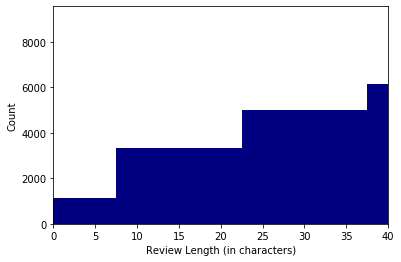

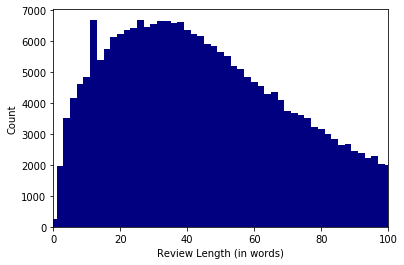

In [83]:

def center(L):
    return [np.mean([a, b]) for (a, b) in zip(L[:-1], L[0:])]

nb = 200
bw = 3000. / (1*nb)
b, e = np.histogram(list(flat_df.comments.apply(lambda x: len(x))), bins=nb, range=(0, 3000))
plt.bar(center(e), b, width=bw, lw=0, facecolor = 'navy')
plt.xlim(0, 40)
plt.xlabel('Review Length (in characters)')
plt.ylabel('Count')
plt.show()

nb = 250
bw = 500. / (1*nb)
b, e = np.histogram(list(flat_df.comments.apply(lambda x: len(x.split(' ')))), bins=nb, range = (0, 500))
plt.bar(center(e), b, width=bw, lw=0, facecolor = 'navy')
plt.xlim(0, 100)
plt.xlabel('Review Length (in words)')
plt.ylabel('Count')
plt.show()

In [118]:
'The host canceled my reservation'.lower()[:32] == 'the host canceled my reservation'

True

In [148]:
for c in flat_df[flat_df.comments.apply(lambda x: len(x.split(' ')) < 10)]['comments'][500:550]:
    print(c)

The appartment is clean, the bed is good.
Wonderfull apt and wonderfull host
great location! very nice, clean, roomy, quite place
Great apartment!
Great hospitality!
very nice room so great place
Great place to stay.
Right place in the right spot! Just go there!
Perfect.
Nice apartment in a central location!
Good location. Good price. Will was responsive and flexible.
Had a wonderful stay! Will was very helpful.
great stay!
It's really good~ he is so nice~
Great experience , really big Apartment..
great Harlem Appartment!
Evrythings good
The location gave us ready access to the city.
Great place to stay! Great area and great host
We had a wonderful time staying here. Thank You.
This was a fantastic apartment in a great location.
Great for a short trip. Close to subway!
Clean, quiet, nicely and creatively decorated.
Great location. Quite place in popular place!
Great space and wonderful location! Thank you Justin!
Great place.
Good place to host a large group!
Great Clean place, in a pe

In [104]:
for c in flat_df[flat_df.comments.apply(lambda x: 5 < len(x.split(' ')) < 10)]['comments'][500:550]:
    print(c)

Really nice stay, really friendly host!
We loved staying here and the LES!
Other than a slight miscommunication, everything is superb.
Great host, great apartment and fabulous stay in NYC!
Great space, very clean and photos were accurate.
Great apartment in a cool, lively neighbourhood.
Lovely apt! 6th floor walk up.
Really friendly and responsive host, and nice place.
The apartment was spacious and comfortable.
Host was courteous and prompt in assisting our rental.
Comfortable, very quiet, and well located.
The host canceled my reservation 17 days before arrival.
Very welcome host and great place to stay
Host, apartment, and neighborhood very nice!
Great location, easy access by tube, perfect !
Isabel was a great host. Location was perfect!
Fabulous location we had a great time!!!!!!!
A great place and a fantastic location..
The host canceled my reservation 82 days before arrival.
Very nice host and great room!
Very nice accommodations. Everything was as described.
It was great .. Ver

In [103]:
for c in flat_df[flat_df.comments.apply(lambda x: 10 < len(x.split(' ')) < 20)]['comments'][500:550]:
    print(c)

Rahul and his wife are very welcoming.  The location is perfect for Columbia and the neighborhood is safe.
It was great to be hosted by Purva's parents in the Columbia's campus.
Rahul was a wonderful host! He was very accommodating and made my family's stay in NYC very comfortable.
Very good. The room is fine and very quiet. I had a good time staying at the appartment.
It was a pleasure staying with Teresa. I really recommend her ! :)
Teresa's home was clean and she was accommodating. I would book with her again in the future.
Teresa is so nice and I spent a nice and comfortable and safe trip on nyc!
Teresa is kind, cultivated, generous and charming and I really liked stayed at her apartment. Highly recommended.
This was a great experience !! I highly recommend this option of accommodation in the hearth of Manhattan !!
Great location. Everything was as stated in the description. Teresa was very accommodating.
Great place to stay on the Upper East Side!  Convenient, clean, and Theresa w

In [88]:
print(flat_df[flat_df.comments.apply(lambda x: len(x) < 20)].comments[500:550])

70769           Ok. Room as described.
70783     Joe is great host. Approved.
70896           Thanks for everything!
71067       It's so nice to live here.
71090          Nice and attentive host
71126                 perfect location
71227               I had a great time
71254                     Great place!
71301                  Pretty awesome!
71323      Jo is very nice and helpful
71337    Joe is super nice and helpful
71340             Home away from Home.
71370                            Great
71409            Evrerything was there
71472                      GREAT!!!!!!
71474                 I ❤️ this place!
71500                  Pretty accurate
71505       Perfect Location and Host.
71545          Joe was a gracious host
71573                  Had a nice stay
71589                      Great host!
71623         It's nice place to stay.
71626       Jj is friendly and helpful
71638         Great host . Nice place.
71676                      Great place
71718            Nice and

In [167]:
flat_df.user_id

0              9193
1             26718
3            185050
4            456184
5            351855
            ...    
325677    108482018
325678     43662901
325679     28703397
325680     25112195
325681     16637631
Name: user_id, Length: 280476, dtype: int64

In [168]:
flat_df_newclean = flat_df[flat_df.comments.apply(lambda x: len(x.split(' ')) >= 10)]
flat_df_newclean.comments = flat_df_newclean.comments.apply(lambda x: x.lower())
flat_df_newclean.comments = flat_df_newclean.comments.apply(lambda x: x.replace('\n', ' '))
flat_df_newclean.comments = flat_df_newclean.comments.apply(lambda x: x.replace('\r', ' '))

/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [169]:
pickle_name = datadir + 'flat_df_newclean.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df, pickle_file)

In [170]:
flat_df_newclean

,listing_id,host_name,user_id,comments
0,2515,"18180 Mizi Name: host_name, dtype: object",9193,stephanie's offered all the most important thi...
3,2515,"18180 Mizi Name: host_name, dtype: object",185050,we stayed at the 111th street apartment with s...
4,2515,"18180 Mizi Name: host_name, dtype: object",456184,very conveniently located just north of centra...
5,2515,"18180 Mizi Name: host_name, dtype: object",351855,we had a great stay with stephanie and her fam...
6,2515,"18180 Mizi Name: host_name, dtype: object",363433,we stayed at the chez chic budget room for a w...
...,...,...,...,...
325676,18413899,"3959 Alexa Name: host_name, dtype: object",127641350,"excellent location, comfy bed, and privacy. ho..."
325678,18423403,"8153 Shannon Name: host_name, dtype: object",43662901,great experience! apartment was clean and tidy...
325679,18426417,"18049 Margarita Name: host_name, dtype: object",28703397,margarita is the perfect host. we very much en...
325680,18443436,"16467 Clara Name: host_name, dtype: object",25112195,"clara is a great person, the place below the h..."


In [171]:
fdf_listing_ids = np.unique(flat_df_newclean.listing_id)
fdf_user_ids = np.unique(flat_df_newclean.user_id)

In [173]:
flat_df_newclean.user_id

0              9193
3            185050
4            456184
5            351855
6            363433
            ...    
325676    127641350
325678     43662901
325679     28703397
325680     25112195
325681     16637631
Name: user_id, Length: 265954, dtype: int64

In [452]:
fdf_listing_ids.shape

(14447,)

In [175]:
# get the number of reviews for every listing
# plot the distribution

n_revs_per_listing= np.zeros((len(fdf_listing_ids)))
n_revs_per_user= np.zeros((len(fdf_user_ids)))

print(flat_df_newclean.shape)
for ilist, lid in enumerate(fdf_listing_ids):
    n_revs_per_listing[ilist] = flat_df_newclean[flat_df_newclean.listing_id==lid].shape[0]
for iuid, uid in enumerate(fdf_user_ids):
    n_revs_per_user[iuid] = flat_df_newclean[flat_df_newclean.user_id == uid].shape[0]


(265954, 4)


In [197]:
n_revs_per_user.max()

41.0

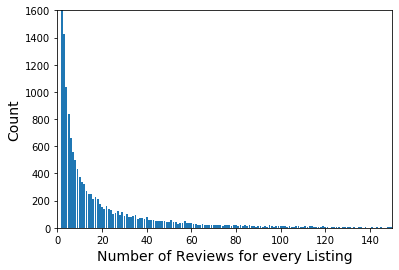

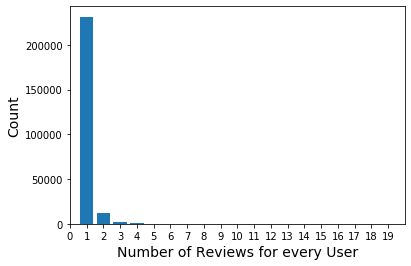

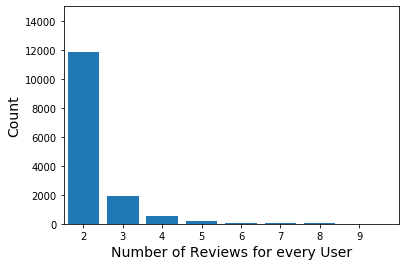

In [241]:
b_rpl, e_rpl = np.histogram(n_revs_per_listing, bins=360, range = (0, 360))
b_rpu, e_rpu = np.histogram(n_revs_per_user, bins = 50, range=(0, 50))
plt.bar(e_rpl[1:], b_rpl)
plt.ylim((0, 1600))
plt.xlim((0, 150))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every Listing', fontsize = 14)
plt.show()

plt.bar(e_rpu[:-1], b_rpu)
plt.xlim(0, 20)
plt.ylim()
plt.xticks(range(20))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every User', fontsize = 14)
plt.show()

plt.bar(e_rpu[:-1], b_rpu)
plt.xlim(1.5, 10)
plt.ylim((0, 15000))
plt.xticks(range(2, 10))
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Number of Reviews for every User', fontsize = 14)
plt.show()

In [258]:
print('Number of listings in NYC:', len(fdf_listing_ids))
print('Number of listings with at least 10 reviews:', len(n_revs_per_listing[n_revs_per_listing >= 10]))
print('\n')
print('mean reviews per listing:', n_revs_per_listing.mean())
print('stdev reviews per listing:', np.std(n_revs_per_listing)),
print('median reviews per listing:', np.median(n_revs_per_listing))


Number of listings in NYC: 14447
Number of listings with at least 10 reviews: 6370


mean reviews per listing: 18.408943033155673
stdev reviews per listing: 28.060631538354368
median reviews per listing: 7.0


In [262]:

print('Number of reviewers who have more than 1 review:', len(n_revs_per_user[n_revs_per_user >= 2]))
print('Proportion of reviewers who have more than 1 review:', 
      round(len(n_revs_per_user[n_revs_per_user >= 2]) / len(n_revs_per_user), 5))


Number of reviewers who have more than 1 review: 14773
Proportion of reviewers who have more than 1 review: 0.05999


In [281]:
flat_df_newclean.host_name = flat_df_newclean.host_name.apply(lambda x: x.values[0])

AttributeError: 'str' object has no attribute 'values'

In [286]:
list_of_host_names[1]

'Mizi'

In [293]:
flat_df_newclean.comments.fillna('')
flat_df_HOST_NAME = deepcopy(flat_df_newclean)
for ic, c in enumerate(flat_df_newclean.comments):
    name = flat_df_newclean.host_name.iloc[ic]
    if name is not np.nan:
        flat_df_HOST_NAME.comments.iloc[ic]=flat_df_newclean.comments.iloc[ic].replace(name, 'HOST_NAME')

TypeError: replace() argument 1 must be str, not float

In [299]:
list(flat_df_HOST_NAME.host_name)[14125]

'Roee'

In [263]:
test = flat_df_newclean.host_name[0]

In [278]:
flat_df_newclean.comments

0         stephanie's offered all the most important thi...
3         we stayed at the 111th street apartment with s...
4         very conveniently located just north of centra...
5         we had a great stay with stephanie and her fam...
6         we stayed at the chez chic budget room for a w...
                                ...                        
325676    excellent location, comfy bed, and privacy. ho...
325678    great experience! apartment was clean and tidy...
325679    margarita is the perfect host. we very much en...
325680    clara is a great person, the place below the h...
325681    jerry was a great host! the linens were clean,...
Name: comments, Length: 265954, dtype: object

In [300]:
flat_df_newclean.host_name.iloc[1123]

'Doti'

In [301]:
pickle_name = datadir + 'flat_df_newclean.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df_newclean, pickle_file)

In [302]:
pickle_name = datadir + 'flat_df_newclean_HOST_NAME.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df_HOST_NAME, pickle_file)

In [303]:
datadir +'flat_df_newclean_HOST_NAME.pkl'

'../../Desktop/Insight Project/airbnb/pickles/flat_df_newclean_HOST_NAME.pkl'

265954

In [310]:
lda04, topics04, corpus04, dictionary04 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=4,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=4 topics')

lda07, topics07, corpus07, dictionary07 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=7 topics')

lda10, topics10, corpus10, dictionary10 =  extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 1000, no_above = .5)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [314]:
[print(t, '\n') for t in topics04]
print('\n')
[print(t, '\n') for t in topics07]
print('\n')
[print(t, '\n') for t in topics10]

(0, '0.044*"place" + 0.032*"locat" + 0.031*"apart" + 0.030*"host" + 0.022*"recommend" + 0.020*"clean" + 0.019*"love" + 0.016*"comfort" + 0.016*"perfect" + 0.013*"amaz"') 

(1, '0.035*"room" + 0.031*"nice" + 0.023*"place" + 0.020*"good" + 0.018*"apart" + 0.017*"clean" + 0.017*"locat" + 0.013*"bathroom" + 0.011*"like" + 0.011*"night"') 

(2, '0.045*"apart" + 0.031*"locat" + 0.028*"subway" + 0.024*"walk" + 0.021*"place" + 0.020*"close" + 0.019*"restaur" + 0.017*"easi" + 0.016*"clean" + 0.015*"park"') 

(3, '0.033*"apart" + 0.028*"place" + 0.027*"check" + 0.024*"time" + 0.020*"locat" + 0.019*"clean" + 0.019*"host" + 0.014*"arriv" + 0.014*"help" + 0.013*"need"') 



(0, '0.025*"place" + 0.023*"room" + 0.021*"time" + 0.015*"host" + 0.015*"check" + 0.015*"arriv" + 0.014*"clean" + 0.013*"apart" + 0.013*"night" + 0.011*"leav"') 

(1, '0.037*"apart" + 0.030*"place" + 0.026*"locat" + 0.026*"check" + 0.022*"host" + 0.021*"recommend" + 0.020*"citi" + 0.019*"need" + 0.017*"perfect" + 0.016*"york"') 

[None, None, None, None, None, None, None, None, None, None]

In [315]:
lda04_tfidf, topics04_tfidf, corpus04_tfidf, dictionary04_tfidf =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=4,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=4 topics')

lda07_tfidf, topics07_tfidf, corpus07_tfidf, dictionary07_tfidf = \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=7,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=7 topics')

lda10_tfidf, topics10_tfidf, corpus10_tfidf, dictionary10_tfidf = \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=10,
                                                              no_below = 1000, no_above = .5)
print('finished tf-idf lda model, n=10 topics')

Loaded File
Made Corpus
finished tf-idf lda model, n=4 topics
Loaded File
Made Corpus
finished tf-idf lda model, n=7 topics
Loaded File
Made Corpus
finished tf-idf lda model, n=10 topics


In [316]:
[print(t, '\n') for t in topics04_tfidf]
print('\n')
[print(t, '\n') for t in topics07_tfidf]
print('\n')
[print(t, '\n') for t in topics10_tfidf]

(0, '0.016*"place" + 0.015*"nice" + 0.015*"host" + 0.012*"help" + 0.012*"recommend" + 0.012*"clean" + 0.011*"thank" + 0.011*"friend" + 0.011*"time" + 0.011*"apart"') 

(1, '0.013*"place" + 0.011*"locat" + 0.011*"apart" + 0.011*"perfect" + 0.010*"love" + 0.010*"host" + 0.009*"super" + 0.009*"recommend" + 0.009*"clean" + 0.009*"amaz"') 

(2, '0.017*"check" + 0.012*"quick" + 0.012*"easi" + 0.011*"apart" + 0.011*"question" + 0.010*"respond" + 0.010*"communic" + 0.010*"place" + 0.009*"arriv" + 0.008*"locat"') 

(3, '0.010*"room" + 0.008*"good" + 0.008*"apart" + 0.007*"night" + 0.007*"bathroom" + 0.007*"nice" + 0.007*"place" + 0.006*"sleep" + 0.006*"bedroom" + 0.006*"small"') 



(0, '0.011*"room" + 0.009*"good" + 0.008*"night" + 0.008*"apart" + 0.008*"bathroom" + 0.007*"place" + 0.007*"sleep" + 0.007*"nice" + 0.007*"nois" + 0.006*"clean"') 

(1, '0.021*"close" + 0.019*"nice" + 0.017*"place" + 0.015*"good" + 0.015*"central" + 0.015*"subway" + 0.015*"clean" + 0.014*"locat" + 0.014*"host" + 0.

[None, None, None, None, None, None, None, None, None, None]

In [321]:
lda04_permissive, topics04_permissive, corpus04_permissive, dictionary04_permissive =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=4,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=4 topics')

lda07_permissive, topics07_permissive, corpus07_permissive, dictionary07_permissive = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=7 topics')

lda10_permissive, topics10_permissive, corpus10_permissive, dictionary10_permissive = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [322]:
[print(t, '\n') for t in topics04_permissive]
print('\n')
[print(t, '\n') for t in topics07_permissive]
print('\n')
[print(t, '\n') for t in topics10_permissive]

(0, '0.023*"apart" + 0.014*"room" + 0.014*"place" + 0.014*"stay" + 0.012*"great" + 0.011*"locat" + 0.010*"clean" + 0.010*"night" + 0.009*"good" + 0.007*"nice"') 

(1, '0.027*"apart" + 0.022*"walk" + 0.018*"park" + 0.018*"locat" + 0.016*"central" + 0.015*"subway" + 0.014*"stay" + 0.013*"time" + 0.012*"great" + 0.010*"minut"') 

(2, '0.055*"great" + 0.042*"stay" + 0.038*"apart" + 0.034*"locat" + 0.032*"place" + 0.025*"host" + 0.020*"clean" + 0.017*"recommend" + 0.015*"perfect" + 0.013*"easi"') 

(3, '0.036*"place" + 0.034*"stay" + 0.027*"nice" + 0.019*"great" + 0.018*"room" + 0.018*"clean" + 0.017*"host" + 0.016*"subway" + 0.015*"locat" + 0.015*"recommend"') 



(0, '0.035*"room" + 0.029*"stay" + 0.023*"place" + 0.019*"nice" + 0.018*"great" + 0.014*"like" + 0.014*"good" + 0.012*"host" + 0.010*"comfort" + 0.010*"clean"') 

(1, '0.030*"apart" + 0.017*"stay" + 0.016*"place" + 0.016*"great" + 0.015*"arriv" + 0.012*"clean" + 0.012*"leav" + 0.011*"host" + 0.011*"time" + 0.010*"need"') 

(2, '0

[None, None, None, None, None, None, None, None, None, None]

In [324]:
lda04_permissive_tfidf, topics04_permissive_tfidf, corpus04_permissive_tfidf, dictionary04_permissive_tfidf =  \
                                    extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=4,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=4 topics')

lda07_permissive_tfidf, topics07_permissive_tfidf, corpus07_permissive_tfidf, dictionary07_permissive_tfidf = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=7,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=7 topics')

lda10_permissive_tfidf, topics10_permissive_tfidf, corpus10_permissive_tfidf, dictionary10_permissive_tfidf = \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = True, n_topics=10,
                                                              no_below = 0, no_above = 1.)
print('finished lda model, n=10 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics


In [325]:
[print(t, '\n') for t in topics04_permissive_tfidf]
print('\n')
[print(t, '\n') for t in topics07_permissive_tfidf]
print('\n')
[print(t, '\n') for t in topics10_permissive_tfidf]

(0, '0.006*"place" + 0.006*"great" + 0.006*"apart" + 0.005*"stay" + 0.005*"nice" + 0.005*"room" + 0.005*"host" + 0.005*"time" + 0.005*"clean" + 0.004*"help"') 

(1, '0.013*"great" + 0.012*"place" + 0.010*"host" + 0.010*"stay" + 0.010*"nice" + 0.010*"locat" + 0.010*"clean" + 0.009*"apart" + 0.009*"recommend" + 0.008*"definit"') 

(2, '0.007*"great" + 0.006*"place" + 0.006*"apart" + 0.006*"walk" + 0.005*"stay" + 0.005*"locat" + 0.005*"close" + 0.005*"restaur" + 0.005*"perfect" + 0.005*"nice"') 

(3, '0.006*"room" + 0.005*"apart" + 0.005*"place" + 0.005*"good" + 0.005*"great" + 0.005*"nice" + 0.005*"clean" + 0.004*"stay" + 0.004*"locat" + 0.004*"night"') 



(0, '0.007*"place" + 0.007*"great" + 0.006*"apart" + 0.006*"stay" + 0.005*"host" + 0.005*"locat" + 0.005*"nice" + 0.005*"michael" + 0.005*"clean" + 0.005*"recommend"') 

(1, '0.012*"great" + 0.011*"place" + 0.010*"locat" + 0.010*"nice" + 0.009*"close" + 0.009*"stay" + 0.009*"apart" + 0.008*"perfect" + 0.008*"clean" + 0.008*"host"') 



[None, None, None, None, None, None, None, None, None, None]

In [330]:
lda04_strict_top, topics04_strict_top, corpus04_strict_top, dictionary04_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=4,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=4 topics')

lda07_strict_top, topics07_strict_top, corpus07_strict_top, dictionary07_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=7 topics')

lda10_strict_top, topics10_strict_top, corpus10_strict_top, dictionary10_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=10 topics')

lda15_strict_top, topics15_strict_top, corpus15_strict_top, dictionary15_strict_top =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=15,
                                                              no_below = 0, no_above = .1)
print('finished lda model, n=15 topics')

Loaded File
Made Corpus
finished lda model, n=4 topics
Loaded File
Made Corpus
finished lda model, n=7 topics
Loaded File
Made Corpus
finished lda model, n=10 topics
Loaded File
Made Corpus
finished lda model, n=15 topics


In [331]:
[print(t, '\n') for t in topics04_strict_top]
print('\n')
[print(t, '\n') for t in topics07_strict_top]
print('\n')
[print(t, '\n') for t in topics10_strict_top]
print('\n')
[print(t, '\n') for t in topics15_strict_top]

(0, '0.014*"wonder" + 0.012*"feel" + 0.011*"visit" + 0.011*"amaz" + 0.010*"enjoy" + 0.010*"come" + 0.009*"felt" + 0.009*"hous" + 0.009*"give" + 0.009*"look"') 

(1, '0.014*"super" + 0.009*"accommod" + 0.009*"bathroom" + 0.009*"amaz" + 0.008*"space" + 0.007*"villag" + 0.006*"towel" + 0.006*"best" + 0.006*"east" + 0.005*"bedroom"') 

(2, '0.014*"station" + 0.012*"minut" + 0.010*"squar" + 0.010*"flat" + 0.009*"kitchen" + 0.009*"small" + 0.009*"near" + 0.008*"question" + 0.008*"littl" + 0.008*"park"') 

(3, '0.014*"street" + 0.012*"park" + 0.009*"block" + 0.008*"away" + 0.008*"nois" + 0.007*"shop" + 0.007*"sleep" + 0.007*"right" + 0.005*"littl" + 0.005*"food"') 



(0, '0.015*"station" + 0.015*"quick" + 0.014*"flat" + 0.013*"minut" + 0.013*"question" + 0.012*"leav" + 0.010*"key" + 0.009*"respond" + 0.009*"answer" + 0.008*"late"') 

(1, '0.021*"park" + 0.016*"squar" + 0.016*"shop" + 0.014*"distanc" + 0.012*"away" + 0.012*"block" + 0.011*"bar" + 0.010*"right" + 0.010*"minut" + 0.010*"street"

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [347]:
flat_df_HOST_NAME.shape[0] * .05, 100*100 / flat_df_HOST_NAME.shape[0]

(13297.7, 0.03760048730231544)

In [348]:
lda10_strict_top_05, topics10_strict_top_05, corpus10_strict_top_05, dictionary10_strict_top_05 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 0, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_strict_top_05]


lda10_st_05_sb0200, topics10_st_05_sb0200, corpus10_st_05_sb0200, dictionary10_st_05_sb0200 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 200, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_st_05_sb0200]


lda07_st_05_sb1000, topics07_st_05_sb1000, corpus07_st_05_sb1000, dictionary07_st_05_sb1000 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=7,
                                                              no_below = 1000, no_above = .05,
                                                     npasses= 10)


Loaded File
Made Corpus
finished lda model, n=10 topics
(0, '0.025*"coffe" + 0.020*"towel" + 0.013*"breakfast" + 0.012*"food" + 0.009*"water" + 0.009*"plenti" + 0.009*"fresh" + 0.009*"store" + 0.008*"fridg" + 0.008*"morn"') 

(1, '0.076*"awesom" + 0.024*"john" + 0.023*"cute" + 0.016*"sweet" + 0.013*"jam" + 0.013*"roommat" + 0.011*"paul" + 0.010*"cool" + 0.010*"ador" + 0.010*"comfi"') 

(2, '0.039*"east" + 0.038*"villag" + 0.019*"west" + 0.016*"soho" + 0.014*"spot" + 0.014*"heart" + 0.013*"upper" + 0.012*"lower" + 0.012*"loft" + 0.012*"explor"') 

(3, '0.039*"view" + 0.038*"better" + 0.021*"couldn" + 0.017*"absolut" + 0.015*"incred" + 0.010*"awesom" + 0.010*"hotel" + 0.009*"extrem" + 0.008*"state" + 0.008*"decor"') 

(4, '0.031*"flat" + 0.027*"transport" + 0.023*"lot" + 0.020*"nearbi" + 0.018*"public" + 0.017*"store" + 0.015*"famili" + 0.015*"plenti" + 0.014*"equip" + 0.013*"groceri"') 

(5, '0.015*"nois" + 0.011*"shower" + 0.011*"door" + 0.011*"floor" + 0.010*"issu" + 0.010*"window" + 

NameError: name 'topics10_st_05_sb1000' is not defined

In [349]:
print('finished lda model, n=7 topics')
[print(t, '\n') for t in topics07_st_05_sb1000]



finished lda model, n=7 topics
(0, '0.035*"respond" + 0.032*"late" + 0.031*"flexibl" + 0.024*"answer" + 0.022*"key" + 0.021*"meet" + 0.017*"earli" + 0.017*"prompt" + 0.016*"flight" + 0.016*"avail"') 

(1, '0.053*"hous" + 0.047*"flat" + 0.038*"metro" + 0.033*"appart" + 0.027*"day" + 0.020*"neighbourhood" + 0.018*"spend" + 0.017*"cosi" + 0.017*"harlem" + 0.016*"warm"') 

(2, '0.022*"food" + 0.019*"train" + 0.018*"lot" + 0.016*"local" + 0.016*"nearbi" + 0.016*"explor" + 0.015*"line" + 0.015*"short" + 0.014*"coffe" + 0.012*"privat"') 

(3, '0.032*"nois" + 0.031*"floor" + 0.025*"price" + 0.023*"transport" + 0.022*"pretti" + 0.019*"valu" + 0.019*"window" + 0.019*"stair" + 0.018*"public" + 0.018*"noisi"') 

(4, '0.023*"guest" + 0.019*"know" + 0.017*"list" + 0.016*"door" + 0.016*"issu" + 0.014*"book" + 0.014*"accur" + 0.014*"think" + 0.013*"wasn" + 0.013*"say"') 

(5, '0.035*"towel" + 0.030*"bed" + 0.023*"water" + 0.022*"shower" + 0.018*"plenti" + 0.017*"wifi" + 0.017*"larg" + 0.015*"equip" + 

[None, None, None, None, None, None, None]

In [350]:

lda10_st_05_sb1000, topics10_st_05_sb1000, corpus10_st_05_sb1000, dictionary10_st_05_sb1000 =  \
                                extract_topic_vectors(datadir+'flat_df_newclean_HOST_NAME.pkl',
                                                             tf_idf = False, n_topics=10,
                                                              no_below = 1000, no_above = .05,
                                                     npasses= 10)
print('finished lda model, n=10 topics')
[print(t, '\n') for t in topics10_st_05_sb1000]

Loaded File
Made Corpus
finished lda model, n=10 topics
(0, '0.051*"absolut" + 0.036*"incred" + 0.030*"studio" + 0.029*"hope" + 0.026*"decor" + 0.020*"return" + 0.018*"soon" + 0.017*"futur" + 0.015*"charm" + 0.015*"truli"') 

(1, '0.103*"hous" + 0.097*"awesom" + 0.091*"better" + 0.058*"appart" + 0.053*"price" + 0.046*"couldn" + 0.046*"valu" + 0.026*"hotel" + 0.023*"david" + 0.022*"ask"') 

(2, '0.037*"flexibl" + 0.034*"late" + 0.029*"meet" + 0.029*"key" + 0.028*"respond" + 0.021*"list" + 0.020*"answer" + 0.020*"earli" + 0.020*"accur" + 0.019*"flight"') 

(3, '0.064*"east" + 0.062*"villag" + 0.038*"lot" + 0.033*"explor" + 0.032*"spot" + 0.031*"west" + 0.029*"heart" + 0.029*"cool" + 0.025*"soho" + 0.022*"upper"') 

(4, '0.028*"towel" + 0.028*"coffe" + 0.022*"breakfast" + 0.022*"take" + 0.016*"care" + 0.015*"offer" + 0.015*"food" + 0.015*"morn" + 0.014*"inform" + 0.014*"know"') 

(5, '0.065*"view" + 0.038*"privat" + 0.027*"share" + 0.026*"attract" + 0.025*"privaci" + 0.018*"guest" + 0.018

[None, None, None, None, None, None, None, None, None, None]

In [376]:
topics10_st_05_sb1000

[(0,
  '0.051*"absolut" + 0.036*"incred" + 0.030*"studio" + 0.029*"hope" + 0.026*"decor" + 0.020*"return" + 0.018*"soon" + 0.017*"futur" + 0.015*"charm" + 0.015*"truli"'),
 (1,
  '0.103*"hous" + 0.097*"awesom" + 0.091*"better" + 0.058*"appart" + 0.053*"price" + 0.046*"couldn" + 0.046*"valu" + 0.026*"hotel" + 0.023*"david" + 0.022*"ask"'),
 (2,
  '0.037*"flexibl" + 0.034*"late" + 0.029*"meet" + 0.029*"key" + 0.028*"respond" + 0.021*"list" + 0.020*"answer" + 0.020*"earli" + 0.020*"accur" + 0.019*"flight"'),
 (3,
  '0.064*"east" + 0.062*"villag" + 0.038*"lot" + 0.033*"explor" + 0.032*"spot" + 0.031*"west" + 0.029*"heart" + 0.029*"cool" + 0.025*"soho" + 0.022*"upper"'),
 (4,
  '0.028*"towel" + 0.028*"coffe" + 0.022*"breakfast" + 0.022*"take" + 0.016*"care" + 0.015*"offer" + 0.015*"food" + 0.015*"morn" + 0.014*"inform" + 0.014*"know"'),
 (5,
  '0.065*"view" + 0.038*"privat" + 0.027*"share" + 0.026*"attract" + 0.025*"privaci" + 0.018*"guest" + 0.018*"roommat" + 0.018*"hospit" + 0.017*"warm" 

In [371]:
topics10_st_05_sb1000_df = pd.DataFrame()
w_df = np.zeros((10, 10))
st_df = np.zeros((10, 10), dtype=str)

for ind, vals in topics10_st_05_sb1000:
    w_label = 'topic_weight_'+ str(ind)
    s_label = 'topic_stem_'+ str(ind)
    weights_x_stems = vals.split(' + ')
    weights = [float(i.split('*')[0]) for i in weights_x_stems]
    stems = [i.split('*')[1][1:-1] for i in weights_x_stems]
    topics10_st_05_sb1000_df[w_label] = weights
    topics10_st_05_sb1000_df[s_label] = stems



,topic_weight_0,topic_stem_0,topic_weight_1,topic_stem_1,topic_weight_2,topic_stem_2,topic_weight_3,topic_stem_3,topic_weight_4,topic_stem_4,topic_weight_5,topic_stem_5,topic_weight_6,topic_stem_6,topic_weight_7,topic_stem_7,topic_weight_8,topic_stem_8,topic_weight_9,topic_stem_9
0,0.051,absolut,0.103,hous,0.037,flexibl,0.064,east,0.028,towel,0.065,view,0.025,floor,0.053,extrem,0.036,store,0.067,flat
1,0.036,incred,0.097,awesom,0.034,late,0.062,villag,0.028,coffe,0.038,privat,0.023,nois,0.052,famili,0.023,plenti,0.052,transport
2,0.030,studio,0.091,better,0.029,meet,0.038,lot,0.022,breakfast,0.027,share,0.017,door,0.029,short,0.022,groceri,0.048,metro
3,0.029,hope,0.058,appart,0.029,key,0.033,explor,0.022,take,0.026,attract,0.016,problem,0.025,advertis,0.021,larg,0.042,day
4,0.026,decor,0.053,price,0.028,respond,0.032,spot,0.016,care,0.025,privaci,0.016,issu,0.023,book,0.020,bed,0.037,downtown
5,0.020,return,0.046,couldn,0.021,list,0.031,west,0.015,offer,0.018,guest,0.014,stair,0.022,clear,0.020,nearbi,0.035,train
6,0.018,soon,0.046,valu,0.020,answer,0.029,heart,0.015,food,0.018,roommat,0.013,noisi,0.022,instruct,0.019,food,0.035,public
7,0.017,futur,0.026,hotel,0.020,earli,0.029,cool,0.015,morn,0.018,hospit,0.013,window,0.021,attent,0.018,equip,0.031,harlem
8,0.015,charm,0.023,david,0.020,accur,0.025,soho,0.014,inform,0.017,warm,0.012,wasn,0.019,michael,0.017,size,0.028,line
9,0.015,truli,0.022,ask,0.019,flight,0.022,upper,0.014,know,0.017,talk,0.012,light,0.018,amen,0.016,shower,0.020,alex


In [386]:
w_cols = ['topic_weight_'+str(i) for i in range(10)]
s_cols = ['topic_stem_'+str(i) for i in range(10)]
print(w_cols)
print(s_cols)
topics10_st_05_sb1000_df[s_cols]

['topic_weight_0', 'topic_weight_1', 'topic_weight_2', 'topic_weight_3', 'topic_weight_4', 'topic_weight_5', 'topic_weight_6', 'topic_weight_7', 'topic_weight_8', 'topic_weight_9'] ['topic_stem_0', 'topic_stem_1', 'topic_stem_2', 'topic_stem_3', 'topic_stem_4', 'topic_stem_5', 'topic_stem_6', 'topic_stem_7', 'topic_stem_8', 'topic_stem_9']


,topic_stem_0,topic_stem_1,topic_stem_2,topic_stem_3,topic_stem_4,topic_stem_5,topic_stem_6,topic_stem_7,topic_stem_8,topic_stem_9
0,absolut,hous,flexibl,east,towel,view,floor,extrem,store,flat
1,incred,awesom,late,villag,coffe,privat,nois,famili,plenti,transport
2,studio,better,meet,lot,breakfast,share,door,short,groceri,metro
3,hope,appart,key,explor,take,attract,problem,advertis,larg,day
4,decor,price,respond,spot,care,privaci,issu,book,bed,downtown
5,return,couldn,list,west,offer,guest,stair,clear,nearbi,train
6,soon,valu,answer,heart,food,roommat,noisi,instruct,food,public
7,futur,hotel,earli,cool,morn,hospit,window,attent,equip,harlem
8,charm,david,accur,soho,inform,warm,wasn,michael,size,line
9,truli,ask,flight,upper,know,talk,light,amen,shower,alex


In [ ]:
topic10 = pd.DataFrame('topic_stems_10': )

In [340]:
len(dictionary10.items())

773

In [333]:
[print(t, '\n') for t in topics10_strict_top_05]

(0, '0.017*"awesom" + 0.015*"absolut" + 0.013*"incred" + 0.011*"extrem" + 0.010*"michael" + 0.009*"comfi" + 0.008*"hospit" + 0.008*"better" + 0.007*"warm" + 0.007*"make"') 

(1, '0.034*"flat" + 0.025*"hous" + 0.016*"metro" + 0.015*"harlem" + 0.010*"neighbourhood" + 0.009*"line" + 0.008*"equip" + 0.008*"downtown" + 0.008*"train" + 0.007*"appart"') 

(2, '0.012*"nois" + 0.012*"floor" + 0.011*"issu" + 0.009*"door" + 0.009*"shower" + 0.008*"window" + 0.007*"problem" + 0.007*"wasn" + 0.007*"light" + 0.006*"noisi"') 

(3, '0.011*"train" + 0.010*"famili" + 0.010*"short" + 0.009*"store" + 0.008*"plenti" + 0.008*"late" + 0.007*"line" + 0.007*"group" + 0.007*"abl" + 0.006*"earli"') 

(4, '0.013*"late" + 0.013*"key" + 0.011*"problem" + 0.011*"alex" + 0.010*"instruct" + 0.009*"flight" + 0.008*"clear" + 0.008*"list" + 0.008*"contact" + 0.008*"answer"') 

(5, '0.022*"villag" + 0.016*"east" + 0.010*"west" + 0.010*"lot" + 0.009*"coffe" + 0.009*"spot" + 0.009*"heart" + 0.008*"chelsea" + 0.008*"david" +

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
[print(t, '\n') for t in topics10_strict_top_05]

In [392]:
len(n_revs_per_listing)

14447

In [398]:
fname = datadir + 'flat_df_newclean_HOST_NAME.pkl'
file = open(fname, 'rb')
flat_df_newclean_HOST_NAME = pickle.load(file)
file.close()


In [399]:
flat_df_newclean_HOST_NAME.shape

(265954, 4)

In [450]:
fdf_listing_ids_ge20 = fdf_listing_ids[n_revs_per_listing >= 20]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 265954 but corresponding boolean dimension is 14447

In [451]:
fdf_listing_ids.shape

(14447,)

array([0.25745745, 0.2696681 , 0.07539007, 0.40575163, 0.40456645,
       0.22725742, 0.29718346, 0.02827635, 0.35165703, 0.51242225])

In [621]:
random_lids = np.random.permutation(fdf_listing_ids_ge20)
sims_within = np.zeros((len(fdf_listing_ids_ge20)))
sims_between = np.zeros((len(fdf_listing_ids_ge20)))
sims_random =  np.zeros((len(fdf_listing_ids_ge20)))
n_topics = 10
model = lda10_st_05_sb1000
norm=True

flat_df_newclean_HOST_NAME['corpus10_st_05_sb1000'] = corpus10_st_05_sb1000
for i, lid in enumerate(fdf_listing_ids_ge20):
    if not i % 500:
        print(i)
    #get comments in bag-of-words format
    comments = list(flat_df_newclean_HOST_NAME[flat_df_newclean_HOST_NAME.listing_id == lid].corpus10_st_05_sb1000)
    
    comms_a = comments[::2]
    comms_b = comments[1::2]
    topic_scores_a = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_a])
    topic_scores_b = np.array([get_topic_score(c, model, n_topics, norm) for c in comms_b])
    mean_topic_score_a = np.mean(topic_scores_a, axis=0)
    mean_topic_score_b = np.mean(topic_scores_b, axis=0)
    #print(mean_topic_score_a)
    #print(mean_topic_score_b)
    #print(cosine_similarity(mean_topic_score_a, mean_topic_score_b))
    sims_within[i] = cosine_similarity(mean_topic_score_a, mean_topic_score_b)
    
    random_lid = random_lids[i]
    random_comments = \
        list(flat_df_newclean_HOST_NAME[flat_df_newclean_HOST_NAME.listing_id == random_lid].corpus10_st_05_sb1000)
    random_comms = random_comments[::2]
    random_topic_scores = np.array([get_topic_score(c, model, n_topics, norm) for c in random_comms])
    random_mean_topic_score = np.mean(random_topic_scores, axis=0)
    #print(random_mean_topic_score)
    #print(cosine_similarity(mean_topic_score_a, random_mean_topic_score))
    sims_between[i] = cosine_similarity(mean_topic_score_a, random_mean_topic_score) 
    
    r = np.random.uniform(low=0, high=1.0, size=10)
    r_norm = r/ np.linalg.norm(r)
    sims_random_norm[i] = cosine_similarity(mean_topic_score_a, r_norm)

0
500
1000
1500
2000
2500
3000
3500


In [614]:
np.mean(sims_random_norm, axis=0)

0.7670089074038959

In [604]:
fdf_with_misfortune = flat_df_newclean_HOST_NAME[flat_df_newclean_HOST_NAME.comments.apply(lambda x: 'unfortunately' in x)]
fdf_with_trendy = flat_df_newclean_HOST_NAME[flat_df_newclean_HOST_NAME.comments.apply(lambda x: 'trendy' in x)]

In [593]:
fdf_with_misfortune.comments.iloc[2]

"cin is such a beautiful person, i really enjoyed her company. her apartment is a bit far but very well connected, just 100 meters from a well connected subway line. its perfect for a long holiday in ny. i wanted to extend my stay but unfortunately it was all pre-booked. i wish to see you again cin, you know who to call when you're in new delhi."

In [610]:
i = 8
df = fdf_with_trendy
c = list(df.corpus10_st_05_sb1000)[i]
text = list(df.comments)[i]
tvec_trend = get_topic_score(c, model, n_topics=10, norm=True)
print(list(tvec_trend))
print(text)

[0.3776506882673125, 0.0, 0.15832379493796708, 0.23224584372679816, 0.0, 0.3376106870619816, 0.7822515241591198, 0.09398520113469366, 0.208910891480639, 0.0]
a.  the location    dave and rick's place is situated in what is probably one of the best locations you can choose in nyc, especially if, like us, you're a first time visitor trying to get your bearings. step out of their apartment; walk one way and you're suddenly in the heart of the west village and gorgeous bleecker street. walk the other and you step in to trendy chelsea with its glorious eateries; or take yet another direction and you find yourself on the highline promenade along the hudson river.  additionally, on the opposite end of their block you'll find a subway station connecting you to the blue a, c and e lines.  there is an abundance of wonderful restaurants and diners within a 5-minute walking radius, suiting every sort of budget, that mike and i were very much spoilt for choice at most mealtimes.   really, the locat

1000
1001


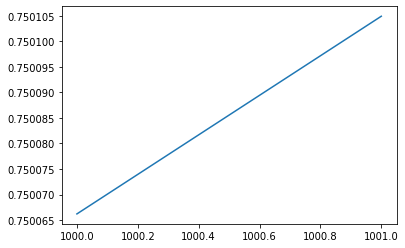

In [647]:
mean_sims = []
for i in range(1000, 1002):
    print(i)
    these_sims = []
    for j in range(100000):
        r1 = np.random.uniform(low=0, high=1.0, size=i)
        r2 = np.random.uniform(low=0, high=1.0, size=i)
        these_sims.append(cosine_similarity(r1, 
                                            r2))
    mean_sims.append(np.mean(these_sims))
plt.plot(range(1000, 1002), mean_sims)
plt.show()
        

In [648]:
mean_sims

[0.7500662007024224, 0.7501048939968434]

In [635]:
print(np.median(sims_within), np.median(sims_between))
print(sc.stats.mannwhitneyu(sims_within, sims_between))


0.9280215524870081 0.8049345864754155
MannwhitneyuResult(statistic=2180337.0, pvalue=0.0)


In [620]:
sims_within_norm

array([0., 0., 0., ..., 0., 0., 0.])

In [626]:
0.7670089074038959**

0.9738230294695316

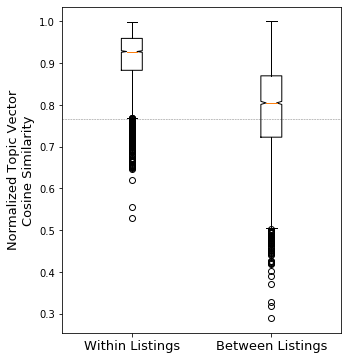

In [623]:
plt.figure(1, (5, 6))
plt.boxplot([sims_within, sims_between], notch = True)
plt.gca().set_xticklabels(['Within Listings', 'Between Listings'], fontsize=13)
plt.ylabel('Normalized Topic Vector\nCosine Similarity', fontsize=13)
plt.gca().axhline(0.7670089074038959, ls='--', lw=0.5, alpha=0.5, c='k')



In [739]:
np.array(flat_df_newclean_HOST_NAME[['corpus10_st_05_sb1000', 'listing_id']])[0]

array([list([(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]),
       2515], dtype=object)

In [750]:
for index, row in flat_df_newclean_HOST_NAME.iteritems():
    print(row)

0             2515
3             2515
4             2515
5             2515
6             2515
            ...   
325676    18413899
325678    18423403
325679    18426417
325680    18443436
325681    18491399
Name: listing_id, Length: 265954, dtype: int64
0              Mizi
3              Mizi
4              Mizi
5              Mizi
6              Mizi
            ...    
325676        Alexa
325678      Shannon
325679    Margarita
325680        Clara
325681        Jerry
Name: host_name, Length: 265954, dtype: object
0              9193
3            185050
4            456184
5            351855
6            363433
            ...    
325676    127641350
325678     43662901
325679     28703397
325680     25112195
325681     16637631
Name: user_id, Length: 265954, dtype: int64
0         stephanie's offered all the most important thi...
3         we stayed at the 111th street apartment with s...
4         very conveniently located just north of centra...
5         we had a great stay wit

In [ ]:
topic_score

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe415656290>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe259ac3690>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe4156564d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe415656450>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fe220226490>}

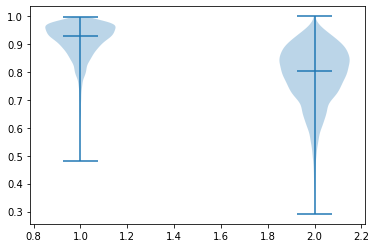

In [573]:
plt.violinplot([sims_within_norm, sims_between_norm], [1, 2], points=500, widths=0.3,
                      showmeans=False, showextrema=True, showmedians=True,)

In [527]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [530]:
cosine_similarity([1, 0, 0], [1, 1, 1])

0.5773502691896258

In [472]:
test = np.array(lda10_st_05_sb1000[flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000.iloc[2]])

In [484]:
test[:, 0].astype(int)

array([5, 7, 9])

In [526]:
test2 = np.zeros((10))
test2[test[:, 0].astype(int)] = test[:, 1]
print(test2)
print(norm(test2))
test2_norm = test2/norm(test2)
print(test2_norm)
print(norm(test2_norm))


[0.         0.         0.         0.         0.         0.26887366
 0.         0.33590093 0.         0.33688295]
0.5464545760789359
[0.         0.         0.         0.         0.         0.49203296
 0.         0.61469141 0.         0.61648848]
1.0


In [489]:
norm([0.49203296, 0.61469141 ,0.61648848])

1.00000000461343

In [498]:
norm([0, 0, 0, 0, 0])

0.0

In [478]:
[6, 6] / norm([6, 6])

array([0.70710678, 0.70710678])

In [499]:
model = lda10_st_05_sb1000

In [820]:
def get_topic_score(comment, model, n_topics, norm=True):
    """
    inputs: a bag-of-words representation of a comment (from a corpus)
    a gensim lda model
    a number of topics
    
    outputs: a normalized vector of size n_topics with the scores of each topic
    """
    model_output = np.array(model[comment])
    inds = model_output[:, 0].astype(int)
    scores = model_output[:, 1]
    out = np.zeros((n_topics))
    out[inds] = scores
    if norm:
        out = out / np.linalg.norm(out)
    return out.astype(float)

In [529]:
np.linalg.norm(np.array([0.24137017, 0.,0.,0.,0.69708091, 0., 0.,0., 0., 0.]))

0.7376864876438073

In [649]:
flat_df_newclean_HOST_NAME.shape

(265954, 5)

In [660]:
a = np.array([1, 0])
b = np.array([[1, 0], [0, 1], [-1, -1]])
cosine_similarity(a, b)

ValueError: shapes (2,) and (3,2) not aligned: 2 (dim 0) != 3 (dim 0)

In [676]:
np.repeat(a[np.newaxis, :], 3, axis=0).shape, b.shape

((3, 2), (3, 2))

In [687]:
np.repeat(a[np.newaxis, :], 3, axis=0), b

(array([[1, 0],
        [1, 0],
        [1, 0]]), array([[ 1,  0],
        [ 0,  1],
        [-1, -1]]))

In [689]:
b.shape

(3, 2)

In [702]:
print(np.dot(a, b.T)/(np.linalg.norm(a)*np.linalg.norm(b.T)),'\n', a, '\n', b.T)

[ 0.5  0.  -0.5] 
 [1 0] 
 [[ 1  0 -1]
 [ 0  1 -1]]


In [710]:
a.shape

(2,)

In [718]:
a.reshape(2, 1).T, b.T

(array([[1, 0]]), array([[ 1,  0, -1],
        [ 0,  1, -1]]))

In [720]:
cosine_similarity(a.T, b.T)

array([ 0.5,  0. , -0.5])

In [665]:
np.linalg.norm(b, axis=1)

array([1.        , 1.        , 1.41421356])

In [679]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [723]:
print(b)
for irow, row in enumerate(b):
    print(row)

[[ 1  0]
 [ 0  1]
 [-1 -1]]
[1 0]
[0 1]
[-1 -1]


In [725]:
flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000

0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
3         [(10, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
4         [(15, 1), (17, 1), (19, 1), (21, 1), (22, 1), ...
5         [(13, 1), (15, 1), (19, 1), (26, 1), (29, 1), ...
6         [(29, 1), (32, 1), (33, 1), (34, 1), (35, 1), ...
                                ...                        
325676              [(41, 1), (196, 1), (236, 1), (325, 1)]
325678    [(46, 1), (84, 1), (130, 1), (153, 1), (242, 1...
325679                                            [(58, 1)]
325680                       [(470, 1), (487, 1), (531, 1)]
325681    [(76, 1), (95, 1), (145, 1), (187, 1), (221, 1...
Name: corpus10_st_05_sb1000, Length: 265954, dtype: object

In [759]:
flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000

0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
3         [(10, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
4         [(15, 1), (17, 1), (19, 1), (21, 1), (22, 1), ...
5         [(13, 1), (15, 1), (19, 1), (26, 1), (29, 1), ...
6         [(29, 1), (32, 1), (33, 1), (34, 1), (35, 1), ...
                                ...                        
325676              [(41, 1), (196, 1), (236, 1), (325, 1)]
325678    [(46, 1), (84, 1), (130, 1), (153, 1), (242, 1...
325679                                            [(58, 1)]
325680                       [(470, 1), (487, 1), (531, 1)]
325681    [(76, 1), (95, 1), (145, 1), (187, 1), (221, 1...
Name: corpus10_st_05_sb1000, Length: 265954, dtype: object

In [815]:
type(flat_df_newclean_HOST_NAME.topic_scores.iloc[0])

numpy.ndarray

In [837]:
test = 

In [838]:
np.vstack(corpus_scores.iloc[:6].apply(lambda c: get_topic_score(c, model,n_topics=10,norm=True)))

(6, 10)

In [840]:
test = pd.DataFrame({'a':[0, 1, 2, 3, 4, 5],
                     'b': corpus_scores.iloc[:6].apply(lambda c: get_topic_score(c, model,n_topics=10,norm=True))})


In [842]:
np.vstack(test.b)

array([[0.32527584, 0.        , 0.        , 0.        , 0.94561918,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.14516399, 0.20241641, 0.        , 0.        ,
        0.        , 0.        , 0.57773628, 0.        , 0.77728747],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49206235, 0.        , 0.61467977, 0.        , 0.61647662],
       [0.01926908, 0.01926971, 0.01926839, 0.01926877, 0.01926925,
        0.23578378, 0.01927031, 0.22732675, 0.01926927, 0.94346671],
       [0.        , 0.        , 0.17255872, 0.        , 0.        ,
        0.63367925, 0.        , 0.        , 0.25038584, 0.71132343],
       [0.        , 0.18159151, 0.3844523 , 0.        , 0.879195  ,
        0.        , 0.        , 0.        , 0.        , 0.21502815]])

In [ ]:
corpus_scores.apply(lambda c: get_topic_score(c, 


In [851]:
# calculate the topic vector of every comment
# on the basis of flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000
corpus_scores = flat_df_newclean_HOST_NAME.corpus10_st_05_sb1000
model = lda10_st_05_sb1000
flat_df_newclean_HOST_NAME['topic_scores'] = corpus_scores.apply(lambda c: get_topic_score(c, 
                                                                                                    model,
                                                                                                    n_topics=10,
                                                                                                   norm=True))
flat_df_newclean_HOST_NAME['topic_scores_unnormalized'] = corpus_scores.apply(lambda c: get_topic_score(c, 
                                                                                                  model,
                                                                                                  n_topics=10,
                                                                                                 norm=False))
pickle_name = datadir + 'flat_df_newclean_HOST_NAME.pkl'
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(flat_df_newclean_HOST_NAME, pickle_file)


In [856]:
room_db.shape, room_db.columns

((19528, 4),
 Index(['room_id', 'host_name', 'user_id', 'comments'], dtype='object'))

In [858]:
flat_df_newclean_HOST_NAME.columns

Index(['listing_id', 'host_name', 'user_id', 'comments',
       'corpus10_st_05_sb1000', 'topic_scores', 'topic_scores_unnormalized'],
      dtype='object')

0             2515
3             2515
4             2515
5             2515
6             2515
            ...   
325676    18413899
325678    18423403
325679    18426417
325680    18443436
325681    18491399
Name: listing_id, Length: 265954, dtype: int64

In [865]:
fdf_s = flat_df_newclean_HOST_NAME.sort_values(by = ['listing_id'])
test = fdf_s.listing_id.apply(lambda lid: np.vstack(fdf_s[fdf_s.listing_id == lid].topic_scores))

In [868]:
test[0].shape

(107, 10)

In [870]:
type(test)

pandas.core.series.Series

In [883]:
test2 = pd.DataFrame({'a': np.array([0, 1, 2])})
b_empty = np.zeros(test2.shape[0])
b_empty[:] = np.nan
test2['b'] = b_empty
test2[test2.a == 2].b = 44
test2

/Users/bennett/anaconda3/envs/airbnb_p3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,a,b
0,0,NaN
1,1,NaN
2,2,NaN


In [892]:
# now restack this df by listing_id
clean_scored_room_db = deepcopy(room_db).sort_values(by=['room_id'])
fdf_s = flat_df_newclean_HOST_NAME.sort_values(by = ['listing_id'])

topic_scores_arr = np.zeros((clean_scored_room_db.shape[0]), dtype=object)
topic_scores_unnormalized_arr = np.zeros((clean_scored_room_db.shape[0]), dtype=object)
for i, lid in enumerate(clean_scored_room_db.room_id):
    
    if lid in fdf_listing_ids:
        this_df = fdf_s[fdf_s.listing_id == lid]
        topic_scores_arr[i] = np.vstack(this_df.topic_scores)
        topic_scores_unnormalized_arr[i] = np.vstack(this_df.topic_scores_unnormalized)
    else:
        topic_scores_arr[i] = np.nan
        topic_scores_unnormalized_arr[i] = np.nan
            
clean_scored_room_db['topic_scores'] = topic_scores_arr
clean_scored_room_db['topic_scores_unnormalized'] = topic_scores_unnormalized_arr
clean_scored_room_db = clean_scored_room_db.dropna(subset = ['topic_scores', 'topic_scores_unnormalized'])
clean_scored_room_db['mean_topic_score'] = \
    clean_scored_room_db['topic_scores'].apply(lambda x: np.mean(x, axis=0))
clean_scored_room_db['mean_topic_score_unnormalized'] = \
    clean_scored_room_db['topic_scores_unnormalized'].apply(lambda x: np.mean(x, axis=0))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [894]:
clean_scored_room_db.columns

Index(['room_id', 'host_name', 'user_id', 'comments', 'topic_scores',
       'topic_scores_unnormalized', 'mean_topic_score',
       'mean_topic_score_unnormalized'],
      dtype='object')

In [895]:
pickle_name = datadir + 'clean_scored_room_db.pkl'
print(pickle_name)
with open(pickle_name, 'wb') as pickle_file:
    pickle.dump(clean_scored_room_db, pickle_file)

../../Desktop/Insight Project/airbnb/pickles/clean_scored_room_db.pkl


(19528, 89)

In [935]:
type(listings[0])

pandas.core.frame.DataFrame

In [923]:
listings_nyc_sorted = listings[0].sort_values(by = 'room_id')
listings_nyc_sorted_clean = listings_nyc_sorted[listings_nyc_sorted.room_id.isin(clean_scored_room_db.room_id)]
rest_of_cols = sorted([c for c in listings_nyc_sorted.columns if c not in clean_scored_room_db.columns])
clean_scored_room_db[rest_of_cols] = listings_nyc_sorted_clean[rest_of_cols]

In [924]:
clean_scored_room_db.shape

(14447, 95)

In [925]:
reviews.shape

(8348173, 6)

In [ ]:

# just this once, process through reviews. add list of reviewer
reviewer_names_for_room = {rid: list(reviews[reviews.listing_id == rid].reviewer_name) 
                               for rid in unique_room_id_list}
'user_name': [reviewer_names_for_room[k] for k in unique_room_id_list],